In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import pandas_profiling
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import pylab as pl
from sklearn.model_selection import train_test_split
plt.style.use('ggplot')

/Users/monnedepraetere/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/monnedepraetere/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/Users/monnedepraetere/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [9]:
# read in data
train = pd.read_csv('/Users/monnedepraetere/Google Drive/3. Coding/Titanic/train.csv')
test = pd.read_csv('/Users/monnedepraetere/Google Drive/3. Coding/Titanic/test.csv')

# crunch the data to get to format that we can feed to logit model
def prepare_the_data(df):
    age_categories = ['1. Very Young', '2. Young','3. Average','4. Old','5. Very Old']
    df['Age_group'] = pd.qcut(df['Age'],5, age_categories)

    larger_than_zero = lambda x: 1 if x > 0 else 0
    df['Has_children'] = df['SibSp'].apply(larger_than_zero)
    df['Has_parent'] = df['Parch'].apply(larger_than_zero)
    df['Part_of_family'] = df['Has_children'] + df['Has_parent']
    df['Part_of_family'] = df['Part_of_family'].apply(lambda x: 1 if x>0 else 0)

    # create dummies for class, age and sex, merge into train dataframe and drop columns we don't need
    dummy_class = pd.get_dummies(df['Pclass'],prefix='class').drop('class_3',1)
    dummy_male = pd.get_dummies(df['Sex']).drop('female', 1)
    df = df.join(dummy_male).join(dummy_class)
    
    return df

train = prepare_the_data(train)

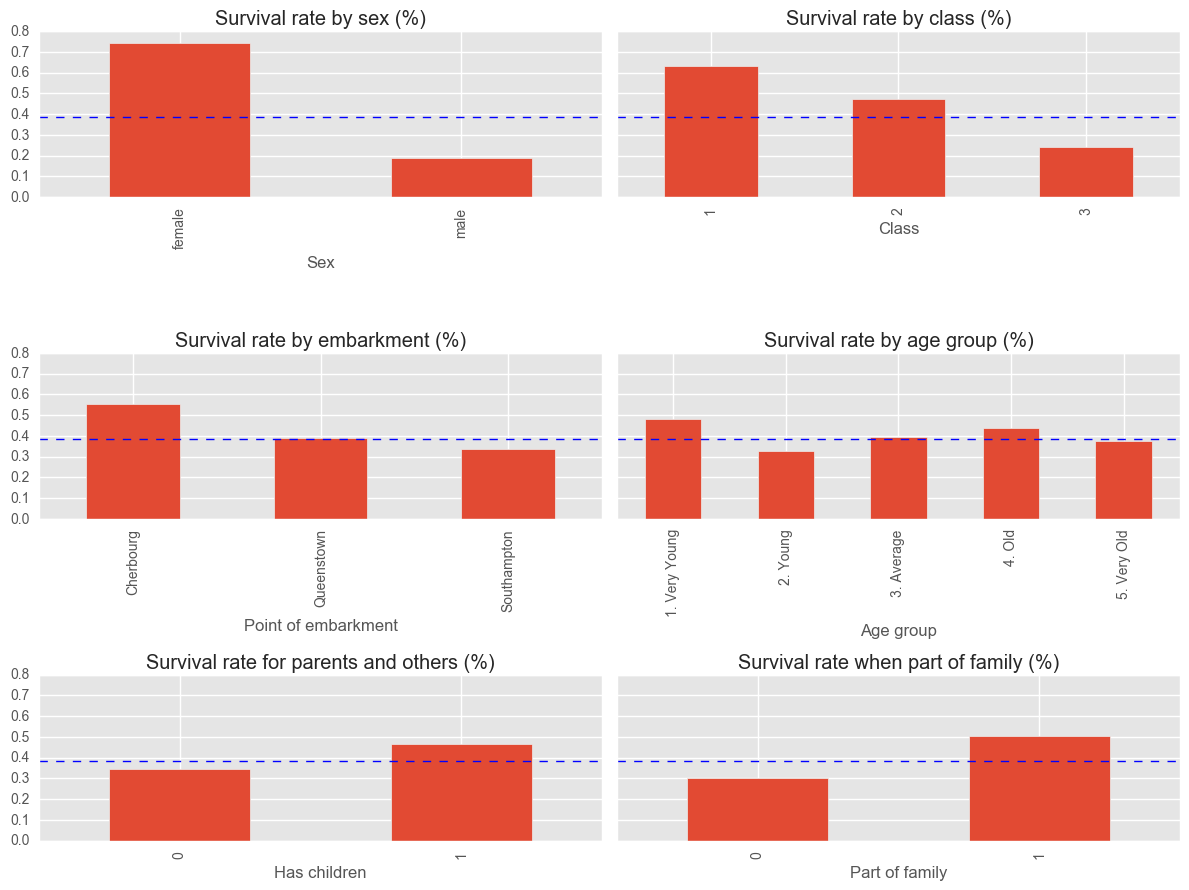

In [34]:
# Calculation and charting of survival rates by group

df = train

survival_rate_by_sex = train_raw.groupby(['Sex']).agg({'Survived':'sum'}) / train_raw.groupby(['Sex']).agg({'Survived':'count'})
survival_rate_by_class = train_raw.groupby(['Pclass']).agg({'Survived':'sum'}) / train_raw.groupby(['Pclass']).agg({'Survived':'count'})
survival_rate_by_embark = train_raw.groupby(['Embarked']).agg({'Survived':'sum'}) / train_raw.groupby(['Embarked']).agg({'Survived':'count'})
survival_rate_by_age = train.groupby(['Age_group']).agg({'Survived':'sum'}) / train.groupby(['Age_group']).agg({'Survived':'count'})
survival_rate_has_children = train.groupby(['Has_children']).agg({'Survived':'sum'}) / train.groupby(['Has_children']).agg({'Survived':'count'}) 
survival_rate_has_parent = train.groupby(['Has_parent']).agg({'Survived':'sum'}) / train.groupby(['Has_parent']).agg({'Survived':'count'}) 
survival_rate_partoffamily = train.groupby(['Part_of_family']).agg({'Survived':'sum'}) / train.groupby(['Part_of_family']).agg({'Survived':'count'})
avg_surv_rate = df.Survived.mean()

fig1,((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(nrows=3,ncols=2,sharey=True,figsize=(12,9))

survival_rate_by_sex.plot(kind = 'bar',ax=ax1)
ax1.set(title='Survival rate by sex (%)')
ax1.set_ylim([0,0.8])
ax1.legend().set_visible(False)
ax1.axhline(y=avg_surv_rate,color='b',label='Average',linestyle='--',linewidth=1)

survival_rate_by_class.plot(kind = 'bar', ax=ax2)
ax2.set(title ='Survival rate by class (%)')
ax2.set(xlabel='Class')
ax2.legend().set_visible(False)
ax2.axhline(y=avg_surv_rate,color='b',label='Average',linestyle='--',linewidth=1)

names = {'C': 'Cherbourg', 'Q': 'Queenstown', 'S': 'Southampton'}
survival_rate_by_embark.rename(index=names).plot(kind = 'bar', ax=ax3)
ax3.set(title ='Survival rate by embarkment (%)')
ax3.set(xlabel='Point of embarkment')
ax3.legend().set_visible(False)
ax3.axhline(y=avg_surv_rate,color='b',label='Average',linestyle='--',linewidth=1)

survival_rate_by_age.plot(kind = 'bar', ax=ax4)
ax4.set(title ='Survival rate by age group (%)')
ax4.set(xlabel='Age group')
ax4.legend().set_visible(False)
ax4.axhline(y=avg_surv_rate,color='b',label='Average',linestyle='--',linewidth=1)

survival_rate_has_children.plot(kind = 'bar', ax=ax5)
ax5.set(title ='Survival rate for parents and others (%)')
ax5.set(xlabel='Has children')
ax5.legend().set_visible(False)
ax5.axhline(y=avg_surv_rate,color='b',label='Average',linestyle='--',linewidth=1)

survival_rate_partoffamily.plot(kind = 'bar', ax=ax6)
ax6.set(title ='Survival rate when part of family (%)')
ax6.set(xlabel='Part of family')
ax6.legend().set_visible(False)
ax6.axhline(y=avg_surv_rate,color='b',label='Average',linestyle='--',linewidth=1)

plt.tight_layout()

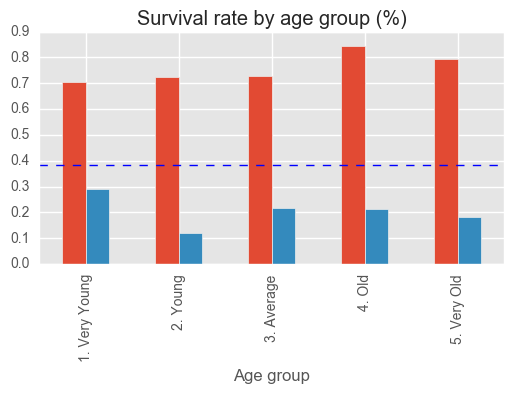

In [41]:
# how do age and sex influence survival rate?
survival_rate_by_age_and_sex = train.groupby(['Age_group','Sex']).agg({'Survived':'sum'})/train.groupby(['Age_group','Sex']).agg({'Survived':'count'})
survival_rate_by_age_and_sex = pd.pivot_table(survival_rate_by_age_and_sex,values='Survived', index='Age_group',columns='Sex')

fig2, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(6,3))
survival_rate_by_age_and_sex.plot(kind = 'bar',ax=ax1)
ax1.set(title ='Survival rate by age group and sex (%)')
ax1.set(xlabel='Age group')
ax1.legend().set_visible(False)
ax1.axhline(y=avg_surv_rate,color='b',label='Average',linestyle='--',linewidth=1)

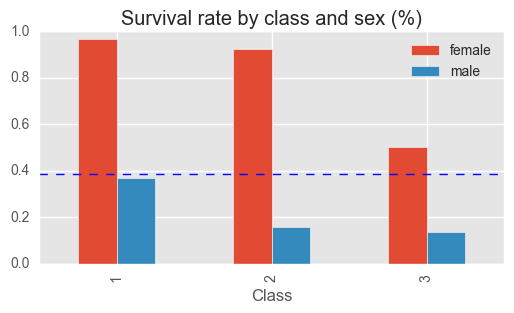

In [45]:
# how do age and class influence survival rate?
survival_rate_by_class_and_sex = train.groupby(['Pclass','Sex']).agg({'Survived':'sum'})/train.groupby(['Pclass','Sex']).agg({'Survived':'count'})
survival_rate_by_class_and_sex = pd.pivot_table(survival_rate_by_class_and_sex,values='Survived', index='Pclass',columns='Sex')

fig2, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(6,3))
survival_rate_by_class_and_sex.plot(kind = 'bar',ax=ax1)
ax1.set(title ='Survival rate by class and sex (%)')
ax1.set(xlabel='Class')
ax1.legend().set_visible(True)
ax1.axhline(y=avg_surv_rate,color='b',label='Average',linestyle='--',linewidth=1)

In [112]:
# what is success rate if we only put sex in our model?
pivot = pd.pivot_table(train, index='Survived',columns='Sex',aggfunc=len,values='PassengerId') / train['PassengerId'].count()
success_rate = 100 * (pivot.loc[0,'male'] + pivot.loc[1,'female'])
print "Using only one variable (Sex) gives estimated success rate of {:.0f}%".format(success_rate)

Using only one variable (Sex) gives estimated success rate of 79%
